In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

from samba.ntstatus import NT_STATUS_GRAPHICS_PATH_NOT_IN_TOPOLOGY
from scanext import CONSTRAINT_RANGE

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
- \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
+ \hbar \omega_c a^{\dagger}a
$$

$$
H_I = \hbar  g \Sigma_x (a^{\dagger} + a).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [63]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--
g = .1 # coupling strength between cavity and atomic system

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .1 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?
mu    = 1. # dipole strength
# evolution
t_max = 50

In [64]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

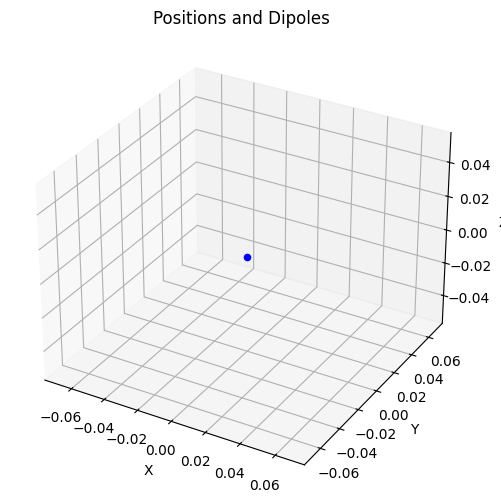

In [65]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [66]:
# Define the ground & the excited states
# atomic dof
ground_state = basis(N_atoms + 1, 0)
excited_states = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]
sm_list = []
atomic_dip = 0
for i in range(N_atoms):
    op = tensor(qeye(2), ground_state * excited_states[i].dag())
    sm_list.append(op)
    atomic_dip += mu * op + mu * op.dag()

# cavity dof
psi0 = basis(2, 0)
psi1 = basis(2, 1)

In [67]:
# initial state
psiini = tensor([psi1, basis(N_atoms+1, 0)]) # = |1>_gamma ø |g>_atom
psiini

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

In [68]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            base = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))* base
            else:
                H +=  omega_a * base # Diagonals except for |0><0|
    H += omega_c * tensor([create(2)*destroy(2), ground_state*ground_state.dag()])

    # interaction Operator
    H += g * atomic_dip * tensor((create(2) + destroy(2)), qeye(N_atoms+1))

    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.1       ]
 [0.         6.28318531 0.1        0.        ]
 [0.         0.1        6.28318531 0.        ]
 [0.1        0.         0.         6.28318531]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [69]:
# Jump / Expect Operators

'''# TRASH DOESNT DO ANYTHING?c_op1 = [np.sqrt(gamma_0) * sum(sm_list)]                                       # COLLECTIVE DECAY??? doesnt work?
# TRASH DOESNT DO ANYTHING?c_op3 = [np.sqrt(gamma_phi) * sum(commutator(sm.dag(), sm) for sm in sm_list)]  # COLLECTIVE DEPHASNG'''

# Define the decay collapse and dephasing operator for each spin
c_op2 = [np.sqrt(gamma_0) * sm for sm in sm_list]                                                          # EVERY ATOM DECAYS on its own
c_op4 = [np.sqrt(gamma_phi) * commutator(sm.dag(), sm) for sm in sm_list]                                  # EVEY ATOM DEPHASES

c_op_list = c_op2 + c_op4

e_op_list = [tensor(psi0 * psi0.dag(),basis(N_atoms+1, i) * basis(N_atoms+1, i).dag()) for i in range(0,N_atoms+1)] #

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 6.580352783203125e-05
    preparation time: 0.00019884109497070312
    run time: 2.8518548011779785
    solver: 'Master Equation Evolution'
    num_collapse: 2
  Time interval: [0.0, 50.0] (50000 steps)
  Number of e_ops: 2
  State not saved.
>


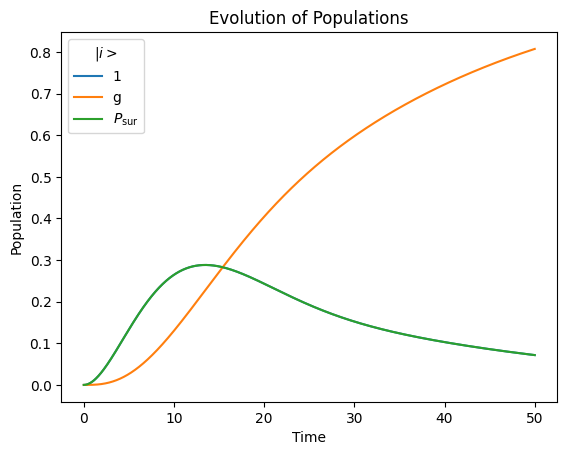

In [70]:
# evolution
times = np.linspace(0, t_max, t_max * 1000) # list of times

result = mesolve(H0, psiini, times, c_ops = c_op_list, e_ops = e_op_list) #, options={"store_states": True}
print(result)
# Plot the expectation values
plt.figure()
for i in range(1, N_atoms+1):
    label = str(i) if i < 5 else None
    plt.plot(times, result.expect[i], label=label)
plt.xlabel("Time")
plt.ylabel("Population")
Psur = sum(result.expect[i] for i in range(1,N_atoms+1)) 
plt.plot(times, result.expect[0], label="g")
plt.plot(times, Psur, label= r"$P_{\text{sur}}$")
plt.legend(title="$|i>$")

plt.title("Evolution of Populations")
plt.show()

In [71]:
# y1: 2D array with shape (len(times), N_atoms) 
y1 = np.array(result.expect[1:]).T # neglect ground state

/tmp/ipykernel_50578/3093229182.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 3 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax1, label=r'$ \vert c_{\alpha}(t)\vert ^2$')


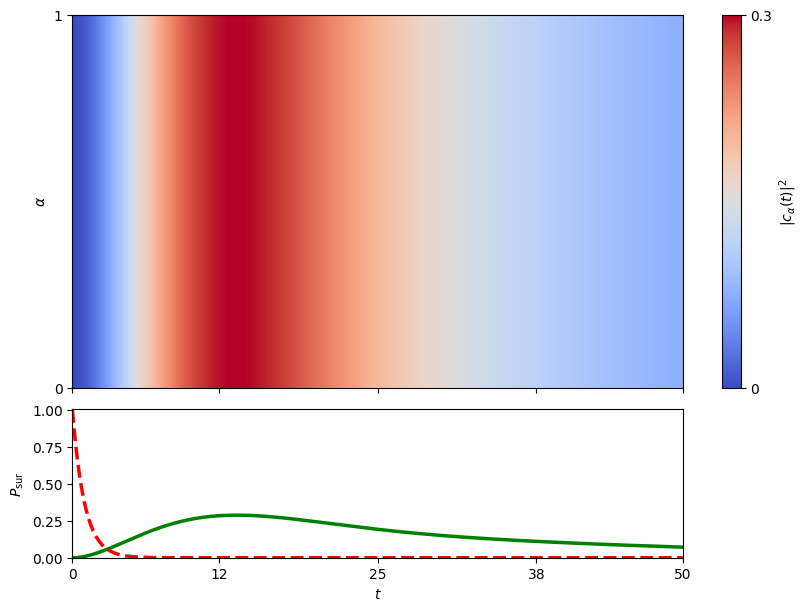

In [72]:
Qfig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]}, constrained_layout=True, figsize=(8,6))

im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, t_max, 0, N_atoms])
yticks = [0] + [i * n_rings for i in range(1, n_chains + 1)] 
ax1.set_yticks(yticks)

ax2.plot(times, Psur, color='green', linewidth=2.5, label='collective')
ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label='1 atom')

max_value = np.max(y1)
cbar = fig.colorbar(im, ax=ax1, label=r'$ \vert c_{\alpha}(t)\vert ^2$')
cbar.set_ticks([0, max_value])
cbar.set_ticklabels([r'0', f'{max_value:.1f}'])

ax2.set_ylim(0, 1.01)
ax2.set_xticks([0, round(t_max/4), round(t_max/2), round(3* t_max/4), t_max])
ax2.set_xticklabels(['0', f'{round(t_max/4)}', f'{round(t_max/2)}', f'{round(3*t_max/4)}', f'{round(t_max)}'])
#ax2.set_yticks([0, Psur[-1], 1])
#ax2.set_yticklabels(['0', f'{Psur[-1]:.2f}', '1'])
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$P_{\text{sur}}$')
plt.show()

In [29]:
E_1_E_2 = 100
E0s = [E_1_E_2, E_1_E_2, E_1_E_2/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
t0s = [t_max//10, t_max//2, t_max/1.3]
Deleta_ts = [t_max/100, t_max/100, t_max/100] # narrow width of the pulses

phis = [0 * np.pi, 0 * np.pi, 0 * np.pi]  # Phase-kick?

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    j = args['j']
    Delta = Deleta_ts[j]
    E0 = E0s[j]
    omega = omegas[j]
    phi = phis[j]
    t0 = t0s[j]
    E = 1 / np.sqrt(2) * E0 * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(omega * (t - t0) + phi)
    return E

In [30]:
def El_field1(t):
    Delta = Deleta_ts[0]
    E0 = E0s[0]
    omega = omegas[0]
    phi = phis[0]
    t0 = t0s[0]
    E = 1 / np.sqrt(2) * E0 * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(omega * (t - t0) + phi)
    return E
def El_field2(t):
    Delta = Deleta_ts[1]
    E0 = E0s[1]
    omega = omegas[1]
    phi = phis[1]
    t0 = t0s[1]
    E = 1 / np.sqrt(2) * E0 * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(omega * (t - t0) + phi)
    return E
def El_field3(t):
    Delta = Deleta_ts[2]
    E0 = E0s[2]
    omega = omegas[2]
    phi = phis[2]
    t0 = t0s[2]
    E = 1 / np.sqrt(2) * E0 * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(omega * (t - t0) + phi)
    return E

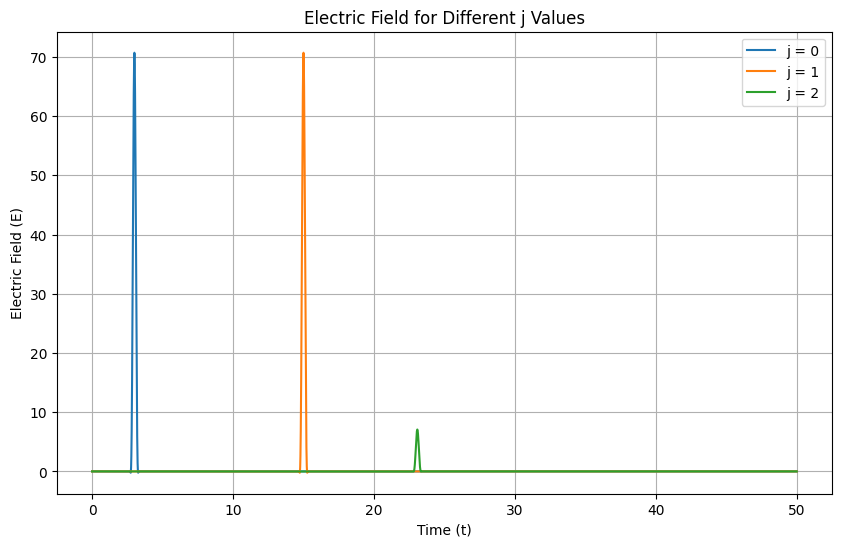

In [73]:
plt.figure(figsize=(10, 6))
for j in range(3):
    E_values = [El_field(ti, {'j': j}) for ti in times]
    plt.plot(times, E_values, label=f'j = {j}')

plt.title('Electric Field for Different j Values')
plt.xlabel('Time (t)')
plt.ylabel('Electric Field (E)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
H = [ H0,           # Time-independent part of the Hamiltonian
[- atomic_dip, El_field1], # H1 with function-based time dependence
[- atomic_dip, El_field2], # H2 (same function)
[- atomic_dip, El_field3], # H3 (same function)
]

In [ ]:
output = mesolve(H, psiini, times, c_op_list, e_op_list)

In [ ]:
# evolution
plt.figure()
for i in range(1, N_atoms+1):
    label = str(i) if i < 5 else None
    plt.plot(times, output.expect[i], label=label)
plt.xlabel("Time")
plt.ylabel("Population")
Psur = sum(output.expect[i] for i in range(1,N_atoms+1))
plt.plot(times, output.expect[0], label="g")
plt.plot(times, Psur, label= r"$P_{\text{sur}}$")
plt.legend(title="$|i>$")

plt.title("Evolution of Populations")
plt.show()

# y1: 2D array with shape (len(times), N_atoms)
y1 = np.array(output.expect[1:]).T # neglect ground state
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]}, constrained_layout=True, figsize=(8,6))

im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, t_max, 0, N_atoms])
yticks = [0] + [i * n_rings for i in range(1, n_chains + 1)]
ax1.set_yticks(yticks)

ax2.plot(times, Psur, color='green', linewidth=2.5, label='collective')
ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label='1 atom')

max_value = np.max(y1)
cbar = fig.colorbar(im, ax=ax1, label=r'$ \vert c_{\alpha}(t)\vert ^2$')
cbar.set_ticks([0, max_value])
cbar.set_ticklabels([r'0', f'{max_value:.1f}'])

ax2.set_ylim(0, 1.01)
ax2.set_xticks([0, round(t_max/4), round(t_max/2), round(3* t_max/4), t_max])
ax2.set_xticklabels(['0', f'{round(t_max/4)}', f'{round(t_max/2)}', f'{round(3*t_max/4)}', f'{round(t_max)}'])
#ax2.set_yticks([0, Psur[-1], 1])
#ax2.set_yticklabels(['0', f'{Psur[-1]:.2f}', '1'])
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$P_{\text{sur}}$')
plt.show()